In [1]:
!pip install requests-oauthlib

In [2]:
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
from datetime import datetime, timedelta

# Your client credentials
client_id = 'Secreto'
client_secret = 'Secreto'

# Create a session
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)

# Get token for the session
token = oauth.fetch_token(token_url='https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token',
                          client_secret=client_secret, include_client_id=True)

# All requests using this session will have an access token automatically added
resp = oauth.get("https://sh.dataspace.copernicus.eu/configuration/v1/wms/instances")
print(resp.content)

b'[]'


In [3]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["F1"],
    output: {
      bands: 3,
    },
  }
}

// Create a Red gradient visualiser from 274-450 K
var viz = ColorGradientVisualizer.createRedTemperature(274, 450)

function evaluatePixel(sample) {
  return viz.process(sample.F1)
}
"""

In [4]:
# Configurar el área de interés (AOI) para la Amazonía
bbox = [-73.0, -15.0, -50.0, 5.0]
crs = "http://www.opengis.net/def/crs/EPSG/0/4326"

# Definir la fecha inicial y el número de días a procesar
start_date = datetime(2024, 7, 28)
num_days = 10  # Número de días para solicitar

for day in range(num_days):
    # Establecer la fecha para cada solicitud
    current_date = start_date + timedelta(days=day)
    start_time_str = current_date.isoformat() + "Z"
    current_date = start_date + timedelta(days=day, hours=23, minutes=59, seconds=59)
    end_time_str = current_date.isoformat() + "Z"
        # Definir la solicitud del proceso con la API
    request = {
        "input": {
            "bounds": {
                "bbox": bbox,
                "properties": {"crs": crs},
            },
            "data": [
                {
                    "type": "sentinel-3-slstr",
                    "dataFilter": {
                        "timeRange": {
                            "from": start_time_str,
                            "to": end_time_str,
                        },
                        "orbitDirection": "DESCENDING",
                    },
                }
            ],
        },
        "output": {
            "width": 512,
            "height": 512,
            "responses": [{"format": {"type": "image/png"}}],
        },
        "evalscript": evalscript,
    }

    # URL para la solicitud de proceso
    url = "https://sh.dataspace.copernicus.eu/api/v1/process"

    # Realizar la solicitud POST a la API
    response = oauth.post(url, json=request)

    # Verificar la respuesta
    if response.status_code == 200:
        # Guardar la imagen recibida con un nombre basado en la fecha
        filename = f"imagen_amazonia_{current_date.strftime('%Y%m%d')}.png"
        with open(filename, "wb") as file:
            file.write(response.content)
            print(f"Imagen guardada como '{filename}'")
    else:
        print(f"Error en la solicitud para {start_time_str} - {end_time_str}: {response.status_code}")
        print(response.text)


Imagen guardada como 'imagen_amazonia_20240728.png'
Imagen guardada como 'imagen_amazonia_20240729.png'
Imagen guardada como 'imagen_amazonia_20240730.png'
Imagen guardada como 'imagen_amazonia_20240731.png'
Imagen guardada como 'imagen_amazonia_20240801.png'
Imagen guardada como 'imagen_amazonia_20240802.png'
Imagen guardada como 'imagen_amazonia_20240803.png'
Imagen guardada como 'imagen_amazonia_20240804.png'
Imagen guardada como 'imagen_amazonia_20240805.png'
Imagen guardada como 'imagen_amazonia_20240806.png'


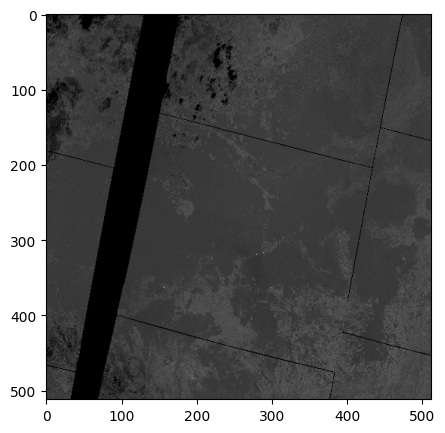

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("imagen_amazonia_20240728.png", cv2.IMREAD_COLOR )
img[img == 255] = 0
cuadrant_size = img.shape[0] // 4
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10, 5))
plt.imshow(img_gray, cmap='gray')


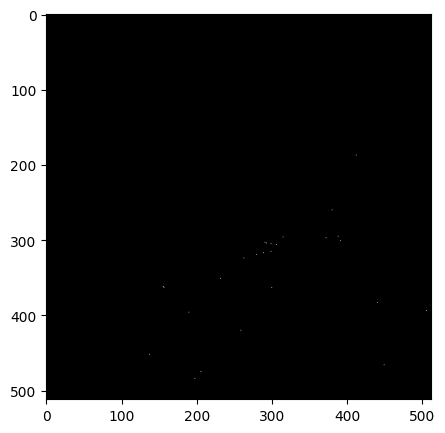

In [16]:
img_gray_2 = img_gray.copy()
img_gray_2[img_gray_2 <= 30] = 0
img_gray_2[img_gray_2 > 30] = 255
plt.figure(figsize=(10, 5))
plt.imshow(img_gray_2, cmap='gray')

In [26]:
conteo = 1
for i in range(1,5):
  size_cuadrant_i_end = cuadrant_size*i
  for j in range(1,5):
    size_cuadrant_j_end = cuadrant_size*j
    img_cuadrant = img_gray_2[size_cuadrant_i_end - cuadrant_size:size_cuadrant_i_end-1, size_cuadrant_j_end - cuadrant_size:size_cuadrant_j_end-1].copy()
    if np.any(img_cuadrant == 255):
      print(f"Cuadrante: {conteo}, Posible incendio")
    conteo += 1

Cuadrante: 8, Posible incendio
Cuadrante: 10, Posible incendio
Cuadrante: 11, Posible incendio
Cuadrante: 12, Posible incendio
Cuadrante: 14, Posible incendio
Cuadrante: 15, Posible incendio
Cuadrante: 16, Posible incendio
